In [86]:
import numpy as np
import cv2
import torch
import glob as glob
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from IPython.display import Image, display

In [87]:
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

In [123]:
# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = create_model(num_classes=3).to(device)
model.load_state_dict(torch.load(
    '../outputs/model100.pth', map_location=device
))
model.eval()

# classes: 0 index is reserved for background
CLASSES = [
    'bkg', 'table', 'cell'
]
# any detection having score below this will be discarded
detection_threshold = 0.95

/home/dhruv/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dhruv/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
# display(Image(filename='../DEMO/10.jpg'))
# get the image file name for saving output later on
image_name = '../DEMO/10.jpg'
image = cv2.imread(image_name)
orig_image = image.copy()
# BGR to RGB
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
# make the pixel range between 0 and 1
image /= 255.0
# bring color channels to front
image = np.transpose(image, (2, 0, 1)).astype(float)
# convert to tensor
image = torch.tensor(image, dtype=torch.float)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image)

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
# carry further only if there are detected boxes
if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # get all the predicited class names
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

    # draw the bounding boxes and write the class name on top of it
    lines = []
    n, c, h, w = image.shape
    for j, box in enumerate(draw_boxes):
        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 2)
        cv2.putText(orig_image, pred_classes[j], 
                    (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
                    2, lineType=cv2.LINE_AA)
    #cv2.imshow('Prediction', orig_image)
    #cv2.waitKey(1)
    cv2.imwrite(f"../DEMO/{image_name}_PRED.jpg", orig_image,)
print('PREDICTION COMPLETE')

PREDICTION COMPLETE


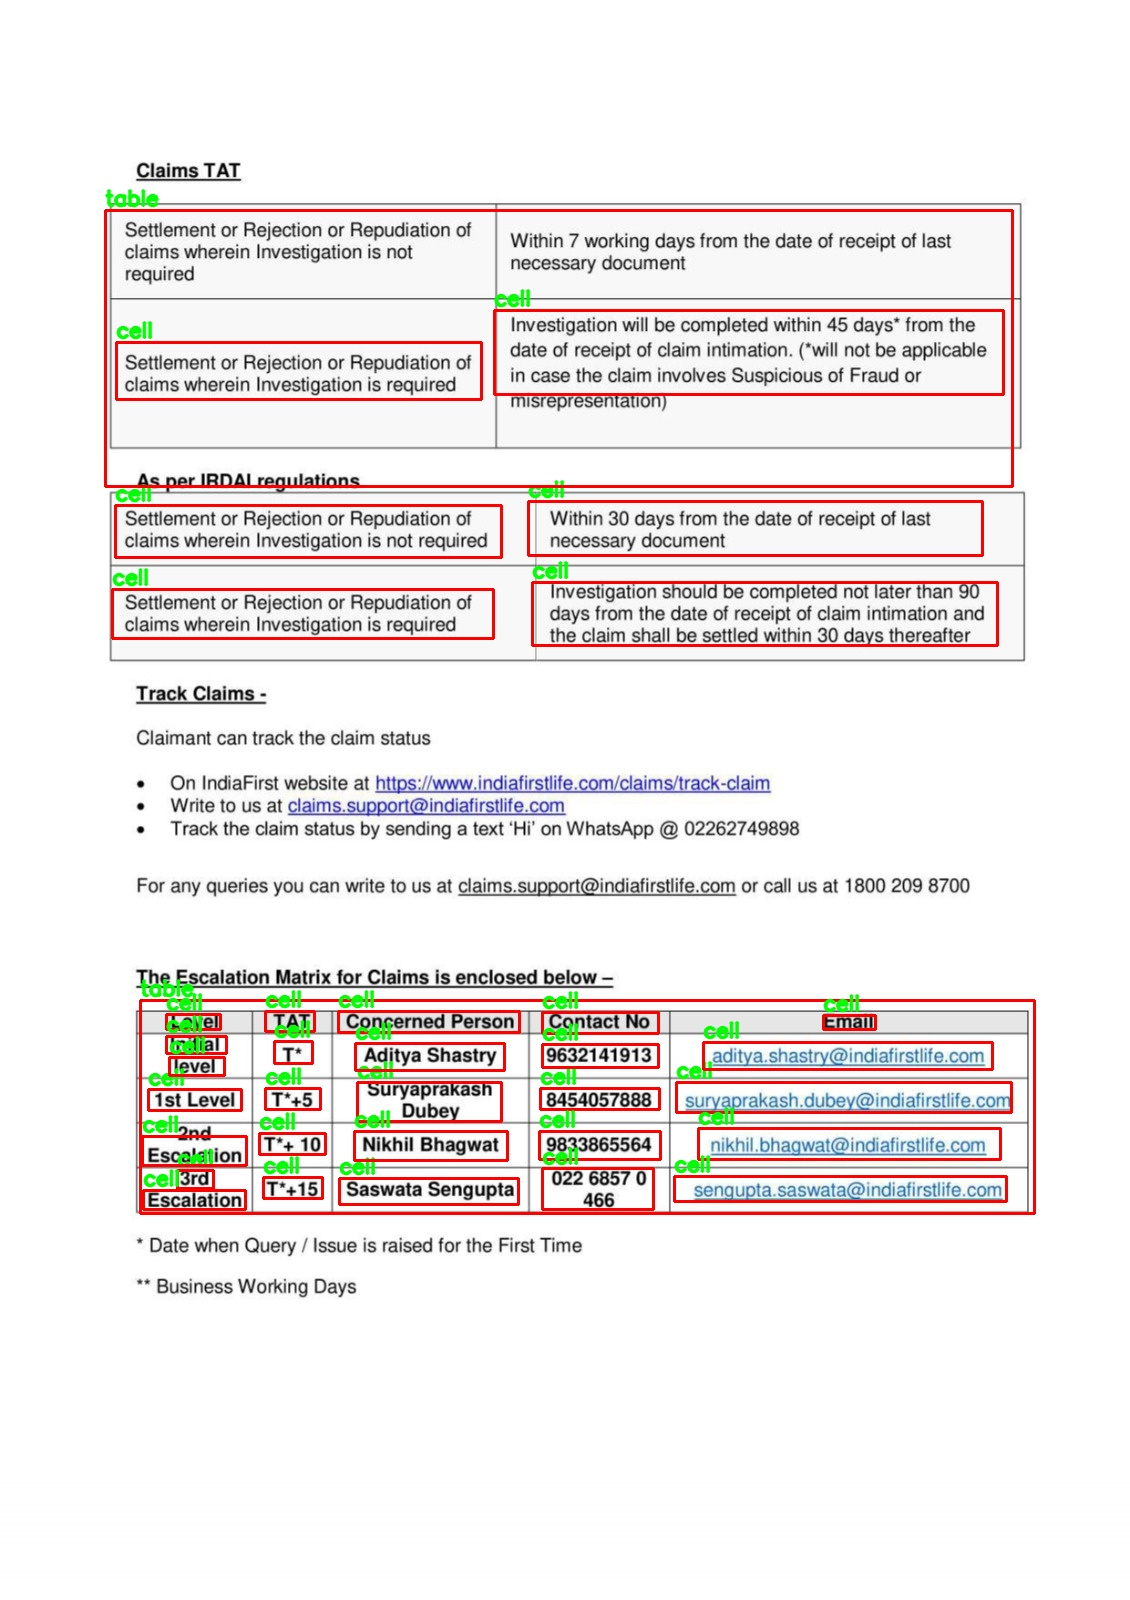

In [125]:
display(Image(filename='../DEMO/10.jpg_PRED.jpg'))

### Process Model Results

In [126]:
# Trim classes for top k boxes predicted over threshold score
classes = pred_classes[:len(boxes)]

# Collect table and cells 
tables = []
cells = []
for i in range(len(boxes)):
    if classes[i] == 'table':
        tables.append(boxes[i])
    else:
        cells.append(boxes[i])

In [127]:
# Returns true if two rectangles b1 and b2 overlap, b is of the form [x1, y1, x2, y2]
def do_overlap(b1, b2):
    if (b1[0] >= b2[2]) or (b1[2] <= b2[0]) or (b1[3] <= b2[1]) or (b1[1] >= b2[3]):
         return False
    else:
        return True

In [128]:
# Get cells which are a part of a table
def get_cells_from_table(tab, cells):
    tablecells = []
    for c in cells:
        overlap = do_overlap(tab, c)
        if overlap:
            tablecells.append(c)
    return tablecells

In [129]:
tables

[array([ 140, 1000, 1034, 1213], dtype=int32),
 array([ 105,  210, 1012,  486], dtype=int32)]

#### Do this for every table of the page

In [135]:
ind = 0
tabcells = get_cells_from_table(tables[0], cells)

# Sort cells based on y coordinates
strcells = sorted(tabcells, key=lambda b:b[1]+b[3], reverse=False)

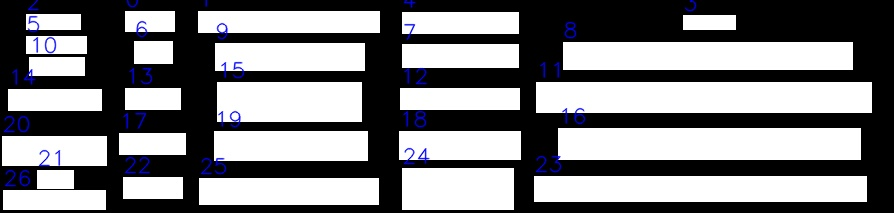

In [136]:
struc_image = cv2.imread('../DEMO/10.jpg')
struc_image = struc_image * 0
for j, box in enumerate(strcells):
    cv2.rectangle(struc_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(255, 255, 255), -1)
    cv2.putText(struc_image, str(j), (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 1), 1, lineType=cv2.LINE_AA)
cropped_image = struc_image[tables[ind][1]:tables[ind][3], tables[ind][0]:tables[ind][2]]

cv2.imwrite(f"../DEMO/struc_PRED.jpg", cropped_image)
display(Image(filename='../DEMO/struc_PRED.jpg'))

In [137]:
# Calculate Mean height
cell_heights = [c[3] - c[1] for c in tabcells]
mean_height = int(np.mean(cell_heights))

In [138]:
# Assign row to each cell based on y coordinate wise arrangement 
cellrow = [0]
assign_row = 0
for i in range(len(strcells) - 1):
    consec_cell_height = strcells[i + 1][1] - strcells[i][1]
    if consec_cell_height > 0.75 * mean_height:
        assign_row = assign_row + 1
    cellrow.append(assign_row)

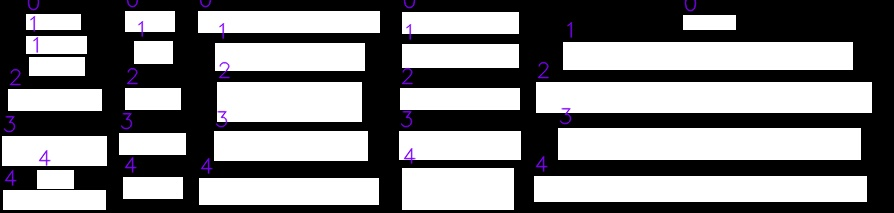

In [139]:
struc_image = cv2.imread('../DEMO/10.jpg')
struc_image = struc_image * 0
for j, box in enumerate(strcells):
    cv2.rectangle(struc_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),(255, 255, 255), -1)
    cv2.putText(struc_image, str(cellrow[j]), (int(box[0]), int(box[1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 128), 1, lineType=cv2.LINE_AA)
cropped_image = struc_image[tables[ind][1]:tables[ind][3], tables[ind][0]:tables[ind][2]]

cv2.imwrite(f"../DEMO/ROW_PRED.jpg", cropped_image)
display(Image(filename='../DEMO/ROW_PRED.jpg'))

In [140]:
# Get number of rows and columns
rows = list(set(cellrow))
nrows = len(rows)
counts = [0] * nrows
for cr in cellrow:
    counts[cr] = counts[cr] + 1
ncols = max(counts)

In [141]:
# Generate row-wise cell sequences of bounding boxes
cellrows = {}
for i in rows:
    cells = []
    for j in range(len(strcells)):
        if i == cellrow[j]:
            cells.append(strcells[j])
    cells = sorted(cells, key=lambda b:b[0], reverse=False)
    cellrows[i] = cells

In [142]:
tableresponse = {}
tableresponse['nrows'] = nrows
tableresponse['ncols'] = ncols
tableresponse['cellrows'] = cellrows

In [143]:
tableresponse

{'nrows': 5,
 'ncols': 6,
 'cellrows': {0: [array([ 166, 1014,  220, 1029], dtype=int32),
   array([ 265, 1011,  314, 1031], dtype=int32),
   array([ 338, 1011,  519, 1032], dtype=int32),
   array([ 542, 1012,  658, 1033], dtype=int32),
   array([ 823, 1015,  875, 1029], dtype=int32)],
  1: [array([ 166, 1036,  226, 1053], dtype=int32),
   array([ 169, 1057,  224, 1075], dtype=int32),
   array([ 274, 1041,  312, 1063], dtype=int32),
   array([ 355, 1043,  504, 1070], dtype=int32),
   array([ 542, 1044,  658, 1067], dtype=int32),
   array([ 703, 1042,  992, 1069], dtype=int32)],
  2: [array([ 148, 1089,  241, 1110], dtype=int32),
   array([ 265, 1088,  320, 1109], dtype=int32),
   array([ 357, 1082,  501, 1121], dtype=int32),
   array([ 540, 1088,  659, 1109], dtype=int32),
   array([ 676, 1082, 1011, 1112], dtype=int32)],
  3: [array([ 142, 1136,  246, 1165], dtype=int32),
   array([ 259, 1133,  325, 1154], dtype=int32),
   array([ 354, 1131,  507, 1160], dtype=int32),
   array([ 539, 

## After function return

In [144]:
import pytesseract

In [145]:
raw_image = cv2.imread('../DEMO/10.jpg')

In [146]:
def get_cell_text(image, cellbbox, i , j):
    cropped_image = image[cellbbox[1]:cellbbox[3], cellbbox[0]:cellbbox[2]]
    text = pytesseract.image_to_string(cropped_image, lang='eng', config='--psm 6')
    cv2.imwrite(f"../DEMO/STRUC_ROW_" + str(i) + " " + "COL_" + str(j) + ".jpg", cropped_image)
    return text

In [147]:
tablerows = tableresponse['nrows']
tablecols = tableresponse['ncols']
tablecellrows = tableresponse['cellrows']

In [148]:
hocr = '<table border=1 style="margin: 0px auto; text-align: center;">'
for i in range(tablerows):
    hocr = hocr + '<tr>'
    rowdata = tablecellrows[i]
    for j in range(tablecols):
        if len(rowdata) < tablecols:
            hocr = hocr + '<td colspan=4>'
            hocr = hocr + get_cell_text(raw_image, rowdata[0], i, j)
            hocr = hocr + '</td>' 
            break
        else:
            hocr = hocr + '<td>'
            hocr = hocr + get_cell_text(raw_image, rowdata[j], i, j)
            hocr = hocr + '</td>' 
    hocr = hocr + '</tr>'
hocr = hocr + '</table>'

In [149]:
f = open('table.html', 'w+')
f.write(hocr)
f.close()